<a href="https://colab.research.google.com/github/Ken-huea/Time-series-analysis/blob/main/SARIMAX%E3%81%AE%E3%81%BF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### データ読み込みと分割

In [ ]:
#いろいろインポート
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# 予測用モジュールのインポート
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm 
from statsmodels.tsa.statespace.sarimax import SARIMAX



#データ読み込み
df = pd.read_csv("3-3_TS_sample2.csv",index_col="年月日",encoding="shift_jis",parse_dates=True)
df.head(5)

,平均気温(℃),降水量の合計(mm),日照時間(時間)
年月日,,,
2010-01-01,4.8,0.0,9.2
2010-01-02,6.3,0.0,9.0
2010-01-03,5.7,0.0,6.6
2010-01-04,6.5,0.0,5.2
2010-01-05,7.3,2.5,8.1


今回はデータをまとめます。一日毎に予測するのではなく、
<font color="red">毎月の平均気温毎に予測</font>するようにしましょう。

1.   データ数を圧縮できる。
2.   それにより学習時間も削減できる。

そして学習用とテスト用にデータ分割もしておきましょう。

In [ ]:
#　2010~2019の期間、月ごとに集計したデータ(平均)。 2019がある。⇒可視化用です。「可視化」にて使用します。
df_month_all = df["2010":"2019"].resample("M").mean()

#　2010~2018の期間、月ごとに集計したデータ(平均)。⇒学習用です。｢学習｣にて使用します。
df_month = df["2010":"2018"].resample("M").mean()


# 2018~2019の期間、月ごとに集計したデータ(平均)。 ⇒「rmse確認」にて使用します。
test_y = df["2019"].resample("M").mean()
test_y = test_y[["平均気温(℃)"]]

In [ ]:
#
df_month_pred = df["2019"].resample("M").mean()
df_month_pred.head(2)

,平均気温(℃),降水量の合計(mm),日照時間(時間)
年月日,,,
2019-01-31,5.596774,0.516129,7.167742
2019-02-28,7.189286,1.500000,4.928571


### 学習

変数の設定。SARIMAXのX部分の設定を行います。

In [ ]:
#予測する材料。SARIMAXのX｡
X = df_month[["降水量の合計(mm)","日照時間(時間)"]]

学習(チューニングなし)。
X部分を設定しましたら、まずは学習してみます。その際引数は特に気にしなくても大丈夫です。

学習できるかどうかを確認するためのものなので。

SARIMAX(endog = y, exog = X, order = param, seasonal_order = param_seasonal)
こんな感じ。

一番右の<font color="red">周期性</font>のみちゃんと設定する必要があります。

In [ ]:
# SARIMA にします. ,seasonal_orderは引数が4つ。左から3つ目までは同じ。一番右のみ設定する必要あり。⇒周期性。
# sarima_model = sm.tsa.SARIMAX(y,X, order=(1,1,1),seasonal_order=(0,1,1,12))


sarimax_model = SARIMAX(y,X, order=(1,1,1),seasonal_order=(1,1,1,12))

#　これはグリッドサーチで確認したパラメータ。

result_sarimax = sarimax_model.fit()

# これで概要を確認する事が出来ます。
result_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            平均気温(℃)   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -141.560
Date:                            Mon, 15 Aug 2022   AIC                            297.120
Time:                                    11:35:19   BIC                            314.997
Sample:                                01-31-2010   HQIC                           304.343
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
降水量の合計(mm)    -0.0077      0.037     -0.209      0.834      -0.079       0.064
日照時間(時間)       0.3580      0.161      2.222      0.026       0.042       0.674
ar.L1          0.2485      0.121      2.062      0.039       0.012       0.485
ma.L1         -0.9986      1.969     -0.507      0.612      -4.857       2.860
ar.S.L12       0.0818      0.147      0.558      0.577      -0.206       0.369
ma.S.L12      -0.9989     33.767     -0.030      0.976     -67.181      65.183
sigma2         0.8373     29.078      0.029      0.977     -56.155      57.830
===================================================================================
Ljung-Box (Q):                       37.38   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.59   Prob(JB):                         0.42
Heteroskedasticity (H):               0.89   Skew:                             0.28
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

チューニング
学習で様子を見たら、チューニングも是非してみましょう。

これはチューニングの独自関数です。他所から引っ張てきました。是非解読してみてください。

良いパラメータを見つけたら、そのパラメータを用いて再度学習してみてください。

In [ ]:
import itertools
p = q = range(0, 3)
sp = sd = sq = range(0, 2)
#p,q,sp,sd,sqの組み合わせのリストを作成する。和分=1,周期=12は固定
pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))] # 3*3 9パターン　

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(sp, sd, sq))] # 2*2*2 8パターン　　72パターン。

list(itertools.product(range(0,3),range(0,3)))

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [ ]:
# worningの無視。
import warnings
warnings.filterwarnings("ignore")

# AICが低かったら更新すると。

best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y,X, order = param, seasonal_order = param_seasonal)
            results = mod.fit()
            print('ARIMAパラメータ{}, 季節変動パラメータ{} - AIC: {}'.format(param, param_seasonal, results.aic))
            
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue

print('AIC最小のモデル：', best_result)
# AIC最小のモデル： [(1, 1, 1), (0, 1, 1, 12), 295.51344145651655]

ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(0, 0, 0, 12) - AIC: 616.0429916950098
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(0, 0, 1, 12) - AIC: 528.1751007210307
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(0, 1, 0, 12) - AIC: 359.31885521794646
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(0, 1, 1, 12) - AIC: 329.0863889091858
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(1, 0, 0, 12) - AIC: 426.939835974348
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(1, 0, 1, 12) - AIC: 398.95831789922437
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(1, 1, 0, 12) - AIC: 351.6329044930587
ARIMAパラメータ(0, 1, 0), 季節変動パラメータ(1, 1, 1, 12) - AIC: 330.86405606701703
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(0, 0, 0, 12) - AIC: 558.438510455266
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(0, 0, 1, 12) - AIC: 498.2884608424406
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(0, 1, 0, 12) - AIC: 320.78100526607477
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(0, 1, 1, 12) - AIC: 297.9021738450555
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(1, 0, 0, 12) - AIC: 401.9742443915624
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(1, 1, 0, 12) - AIC: 314.19302883091535
ARIMAパラメータ(0, 1, 1), 季節変動パラメータ(

### 可視化

重ね合わせ

予測時も同様に外部変数を加えます。


```
exog=df_month_pred[["降水量の合計(mm)","日照時間(時間)"]]
```



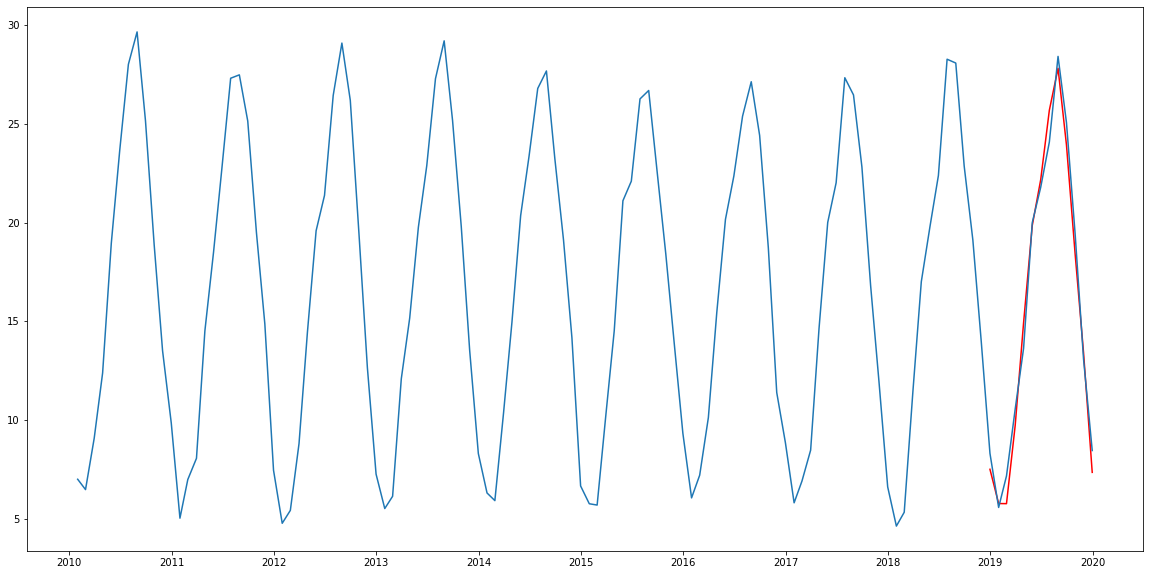

In [ ]:
bestPred = result_sarimax.predict('2018-12', '2019-12',exog=df_month_pred[["降水量の合計(mm)","日照時間(時間)"]])
plt.plot(bestPred, "r")                                     # 赤線。モデルが予測した数値。
plt.plot(df_month_all["平均気温(℃)"])                      #青線。実測値

### rmse確認

まずはtest_yとbestPred_rmseのdf形式を統一しましょう。

そうしなければきちんとrmseを算出する事が出来ません。

bestPredをdf化して新たな変数に格納します。

そしてカラムも統一しています。　　確認がとれたらrmse算出を行いましょう。

In [ ]:

test_y.head(3)

# test_y.columns

,平均気温(℃)
年月日,
2019-01-31,5.596774
2019-02-28,7.189286
2019-03-31,10.561290


In [ ]:
#予測データの作成
#データをpandas化
bestPred_rmse = pd.DataFrame(bestPred)
#最初の行を削除。(2018/12/31)
bestPred_rmse = bestPred_rmse[1:]
bestPred_rmse.head(3)

# bestPred_rmse.columns

,0
2019-01-31,5.795562
2019-02-28,5.788387
2019-03-31,9.735919


In [ ]:
bestPred_rmse = bestPred_rmse.rename(columns = {0:"平均気温(℃)"})
bestPred_rmse.head(5)

,平均気温(℃)
2019-01-31,5.795562
2019-02-28,5.788387
2019-03-31,9.735919
2019-04-30,14.929010
2019-05-31,19.849746


In [ ]:
test_y.head(3)

,平均気温(℃)
年月日,
2019-01-31,5.596774
2019-02-28,7.189286
2019-03-31,10.561290


ここでrmse算出

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
# y_trainと予測値のRMSEを出す
print("RMSE",np.sqrt(MSE(test_y,bestPred_rmse)))

RMSE 0.9615783120597218


### ホワイトノイズの確認
おまけ。このようにホワイトノイズも確認できます。

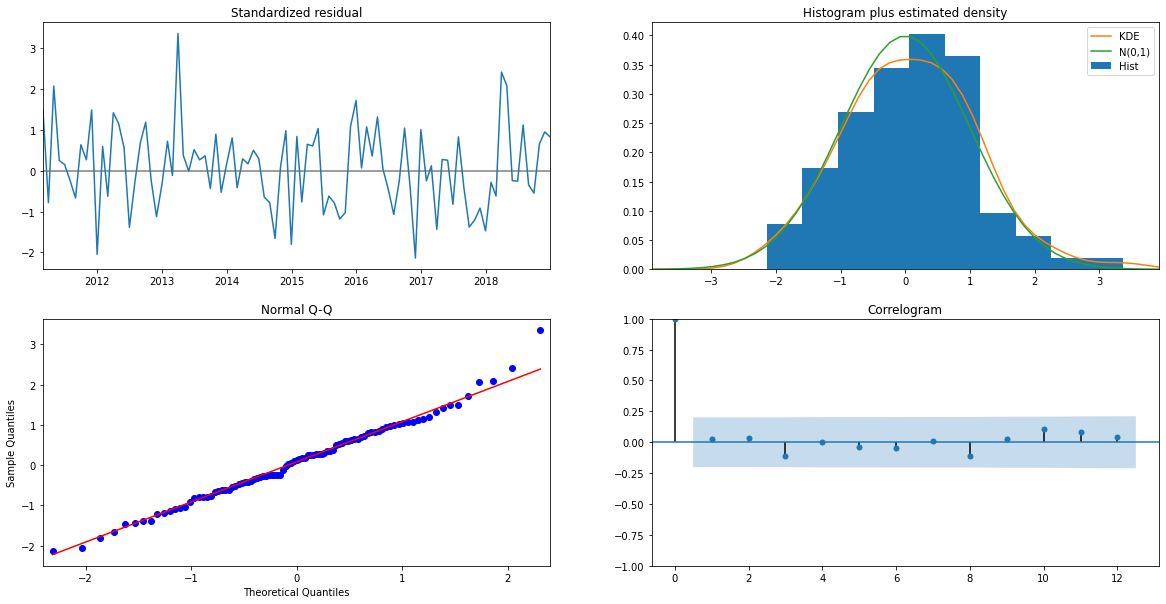

In [ ]:
plt.rc("figure",figsize=(20,10))
result_sarimax.plot_diagnostics(lags=12);